## Load & Inspect the Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
print(df['fico_score'].describe())

count    10000.000000
mean       637.557700
std         60.657906
min        408.000000
25%        597.000000
50%        638.000000
75%        679.000000
max        850.000000
Name: fico_score, dtype: float64


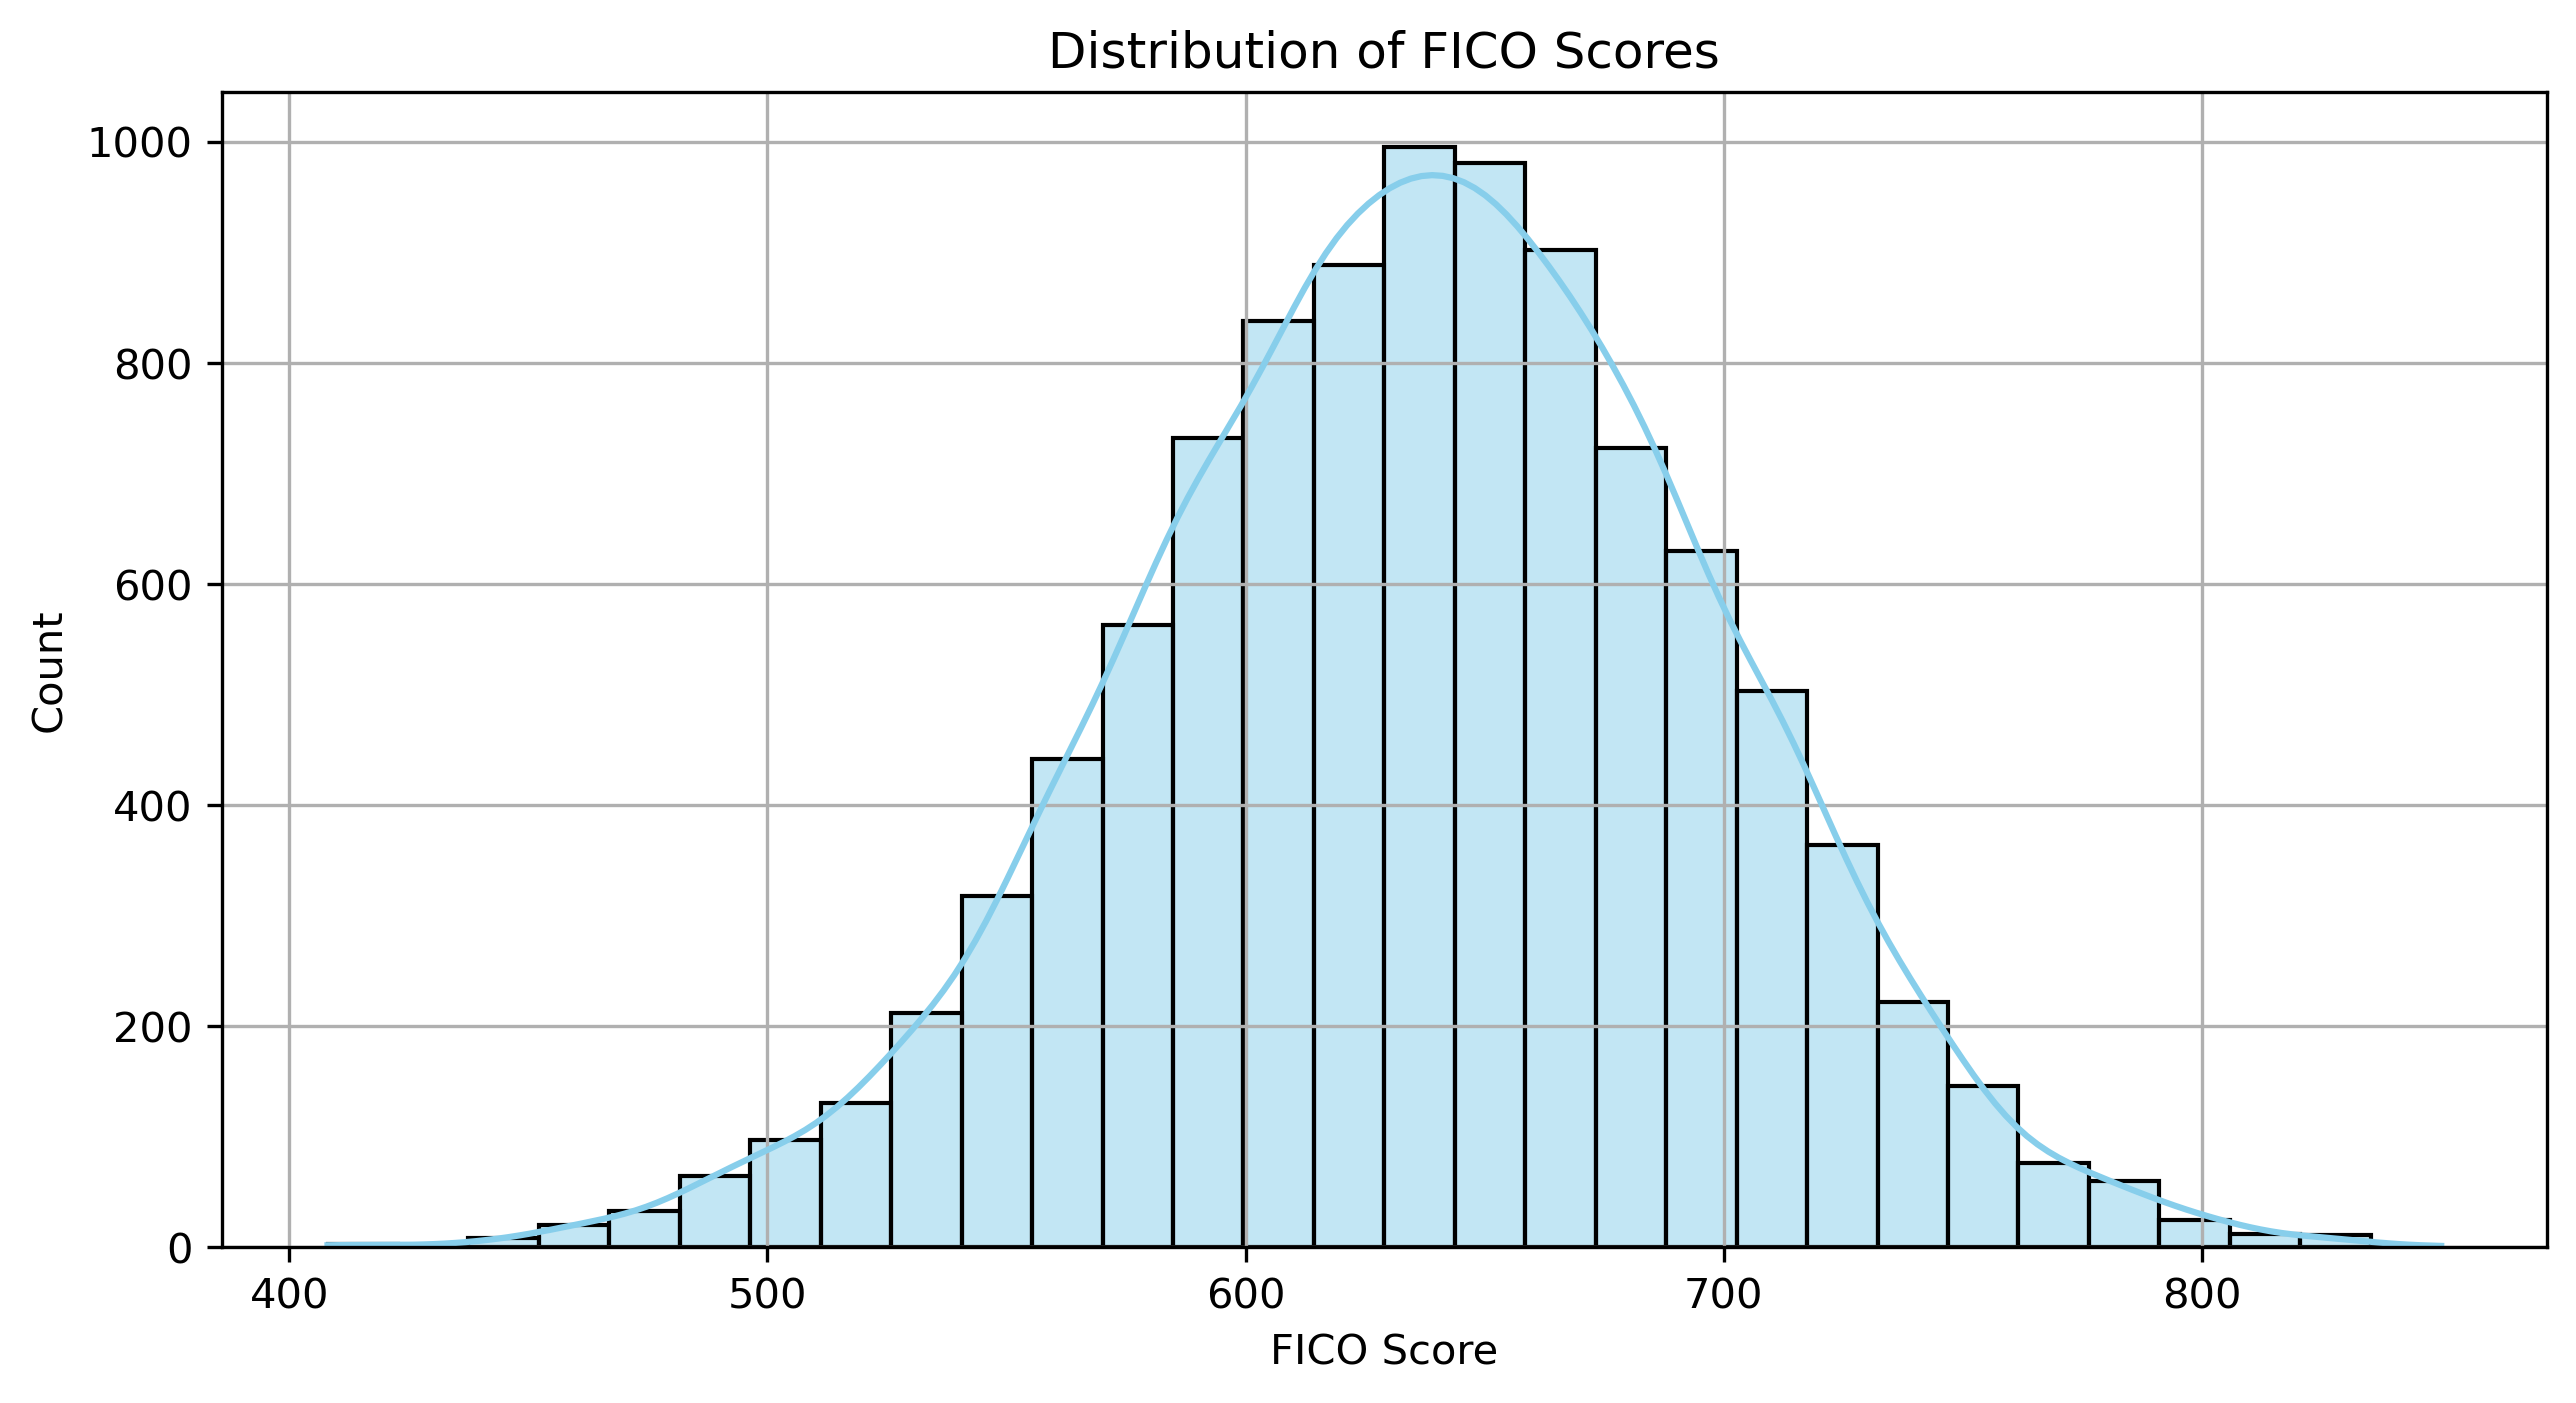

In [4]:
plt.figure(figsize=(10,5), dpi=300)
sns.histplot(df['fico_score'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of FICO Scores")
plt.xlabel("FICO Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Quantize (Bucketize) FICO Scores using MyFICO’s industry-defined ranges.
let's use the ranges from https://www.myfico.com/credit-education/what-is-a-fico-score:
- <580: Poor.
- 580-669: Fair
- 670-739: Good
- 740-799: Very Good
- 800+: Exceptional

In [5]:
def map_fico_score(score):
    if score >= 800:
        return 1  # Exceptional
    elif score >= 740:
        return 2  # Very Good
    elif score >= 670:
        return 3  # Good
    elif score >= 580:
        return 4  # Fair
    else:
        return 5  # Poor

df['fico_rating'] = df['fico_score'].apply(map_fico_score)
print(df[['fico_score', 'fico_rating']].head(10))

   fico_score  fico_rating
0         605            4
1         572            5
2         602            4
3         612            4
4         631            4
5         697            3
6         722            3
7         545            5
8         676            3
9         447            5


/tmp/ipykernel_6106/2972904342.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


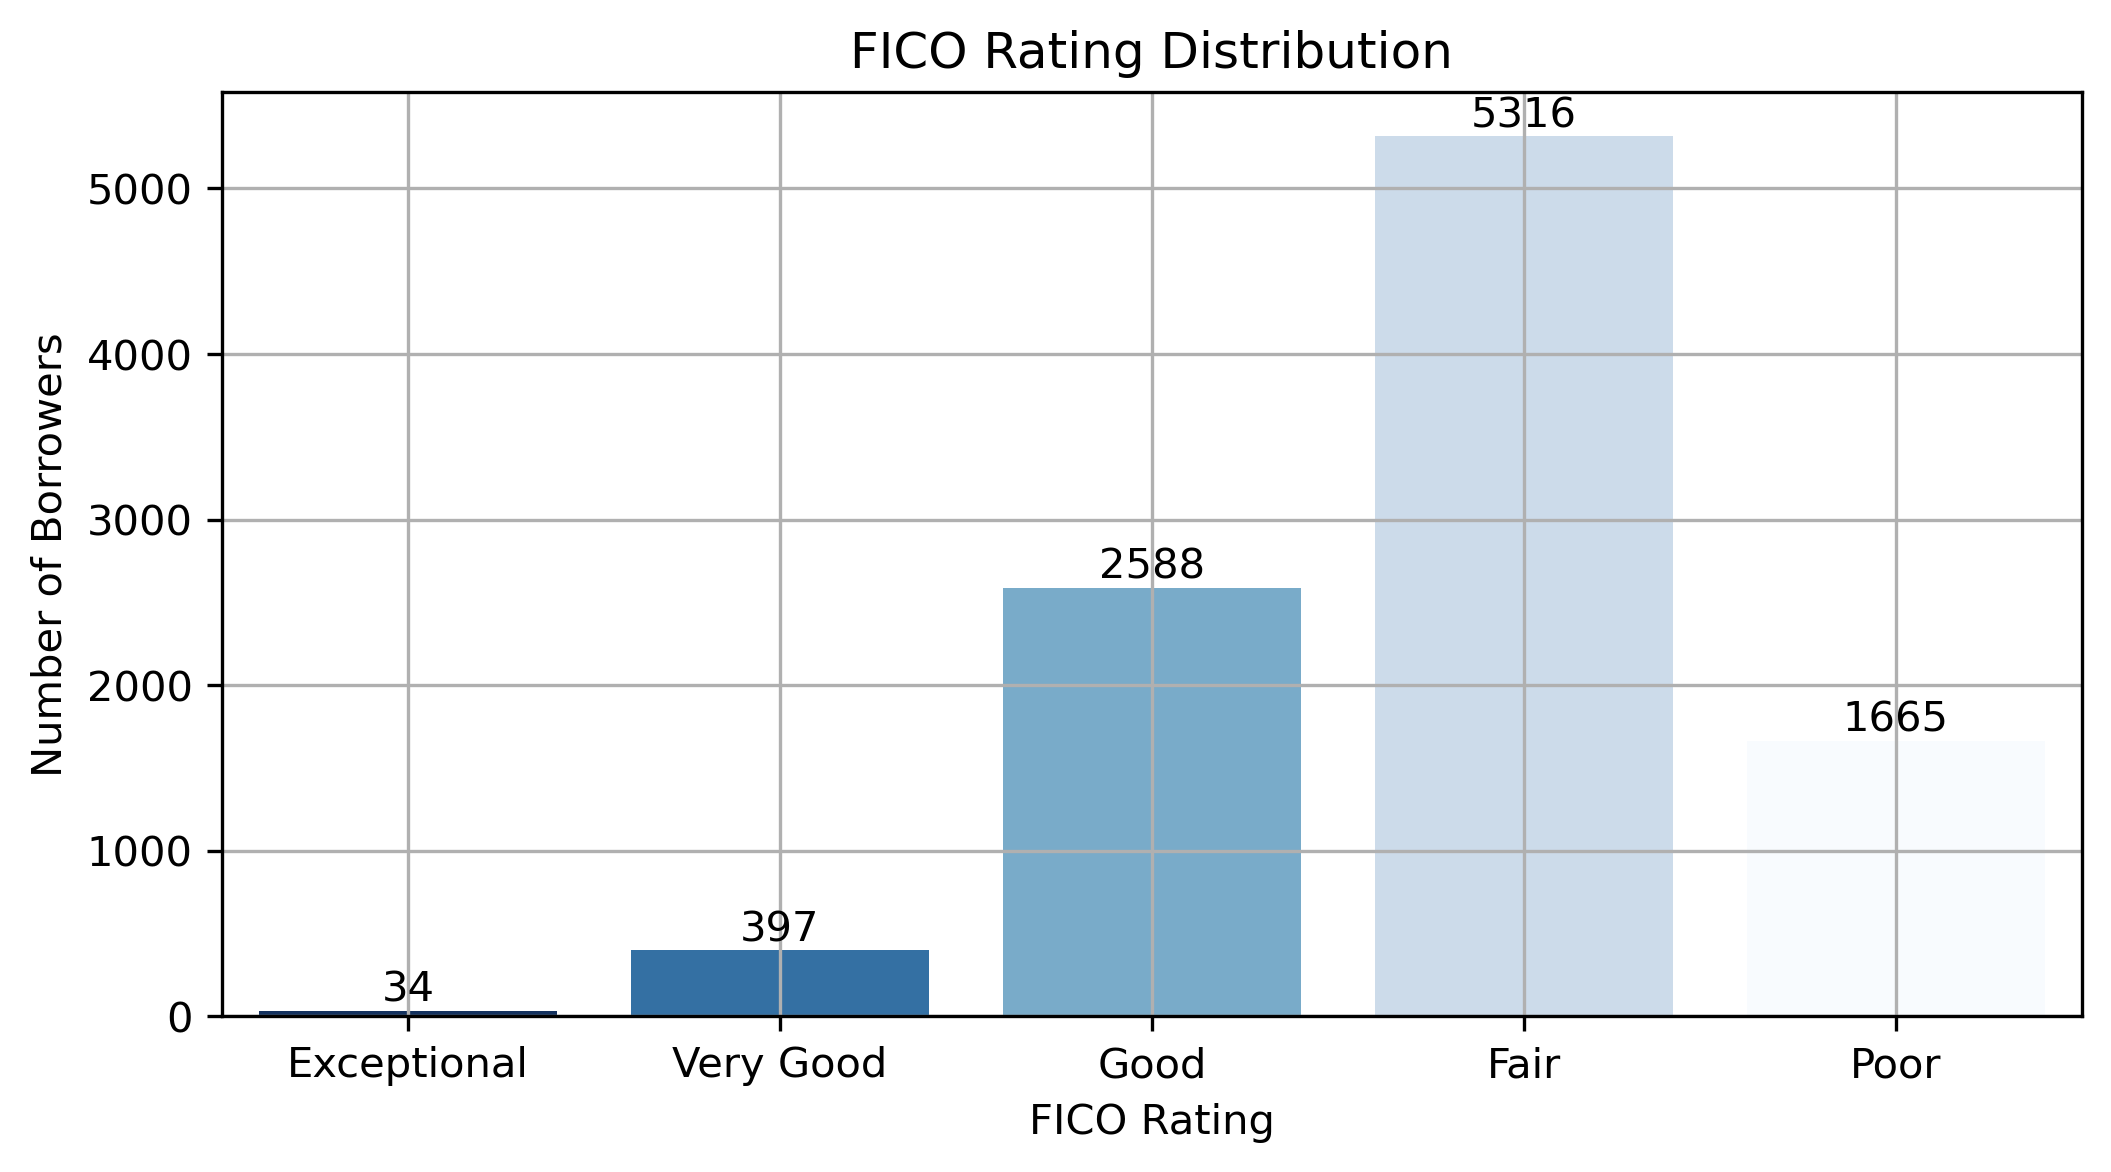

fico_rating
1      34
2     397
3    2588
4    5316
5    1665
Name: count, dtype: int64


In [6]:
rating_labels = {1: "Exceptional", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}
unique_ratings = sorted(df['fico_rating'].unique())
labels = [rating_labels[r] for r in unique_ratings]

plt.figure(figsize=(8,4), dpi = 300)
ax = sns.countplot(x='fico_rating', 
                   hue='fico_rating', 
                   data=df, 
                   order=unique_ratings,
                   palette='Blues_r', 
                   legend=False)

ax.set_xticklabels(labels)
plt.title('FICO Rating Distribution')
plt.xlabel('FICO Rating')
plt.ylabel('Number of Borrowers')
plt.grid(True)

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5,
            int(height), ha="center", va='bottom', fontsize=10)
    
plt.show()
print(df['fico_rating'].value_counts().sort_index())

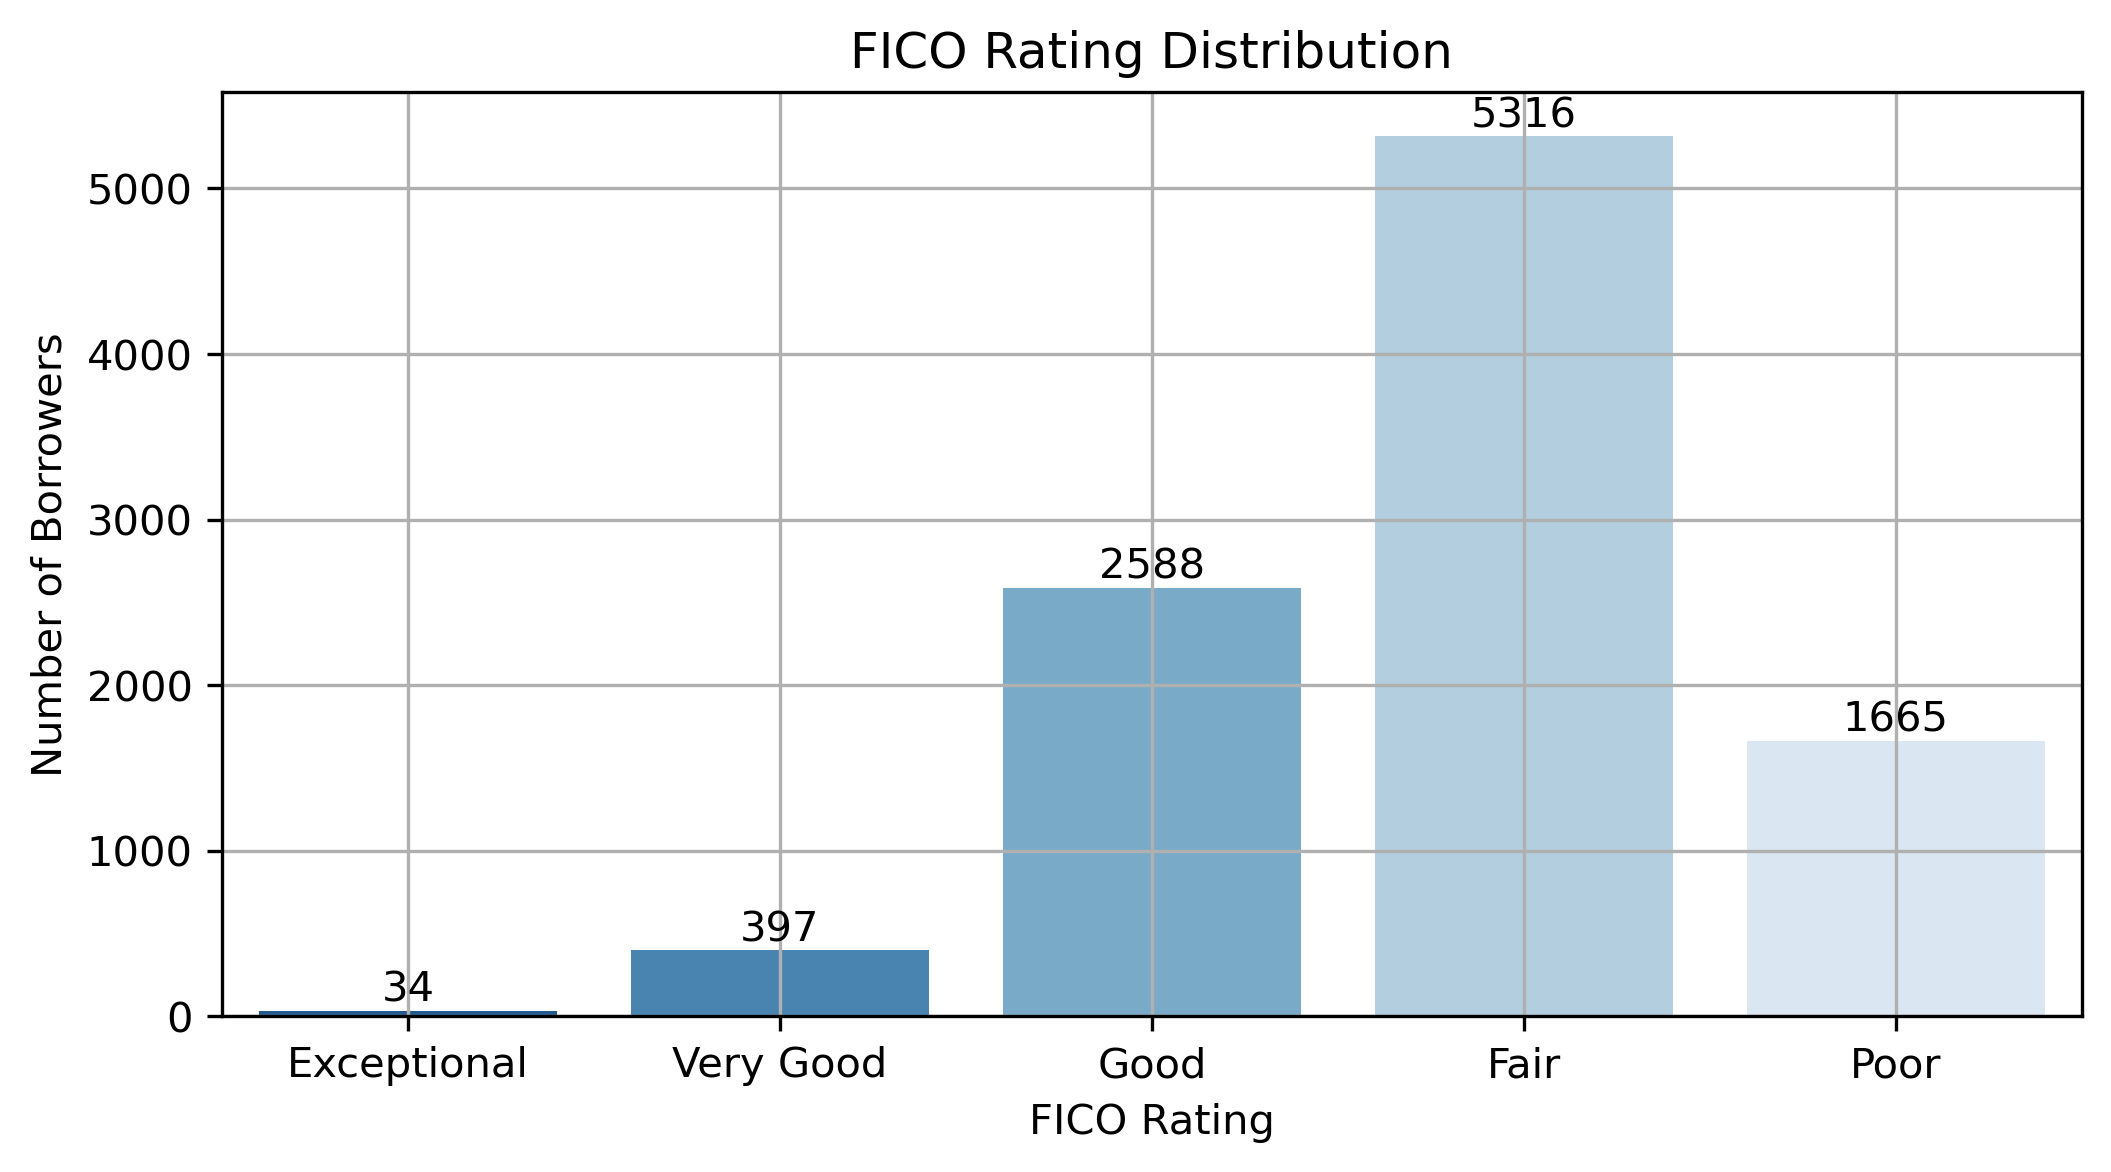

In [7]:
import matplotlib.ticker as ticker

# Rating order and labels
rating_order = [1, 2, 3, 4, 5]
rating_labels = {1: "Exceptional", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}

# Ensure categorical order
df['fico_rating'] = pd.Categorical(df['fico_rating'], categories=rating_order, ordered=True)

# Plot
plt.figure(figsize=(8,4), dpi=300)
ax = sns.countplot(x='fico_rating', 
                   hue='fico_rating', 
                   data=df, palette='Blues_r', 
                   order=rating_order,
                   legend=False)

# Set fixed tick locations and labels to avoid warning
ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(rating_order))))
ax.set_xticklabels([rating_labels[i] for i in rating_order])

plt.title('FICO Rating Distribution')
plt.xlabel('FICO Rating')
plt.ylabel('Number of Borrowers')
plt.grid(True)

# Add count annotations on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5,
            int(height), ha="center", va='bottom', fontsize=10)

plt.show()

## Evaluate How Good the Buckets Are

### Average Default Rate per Bucket

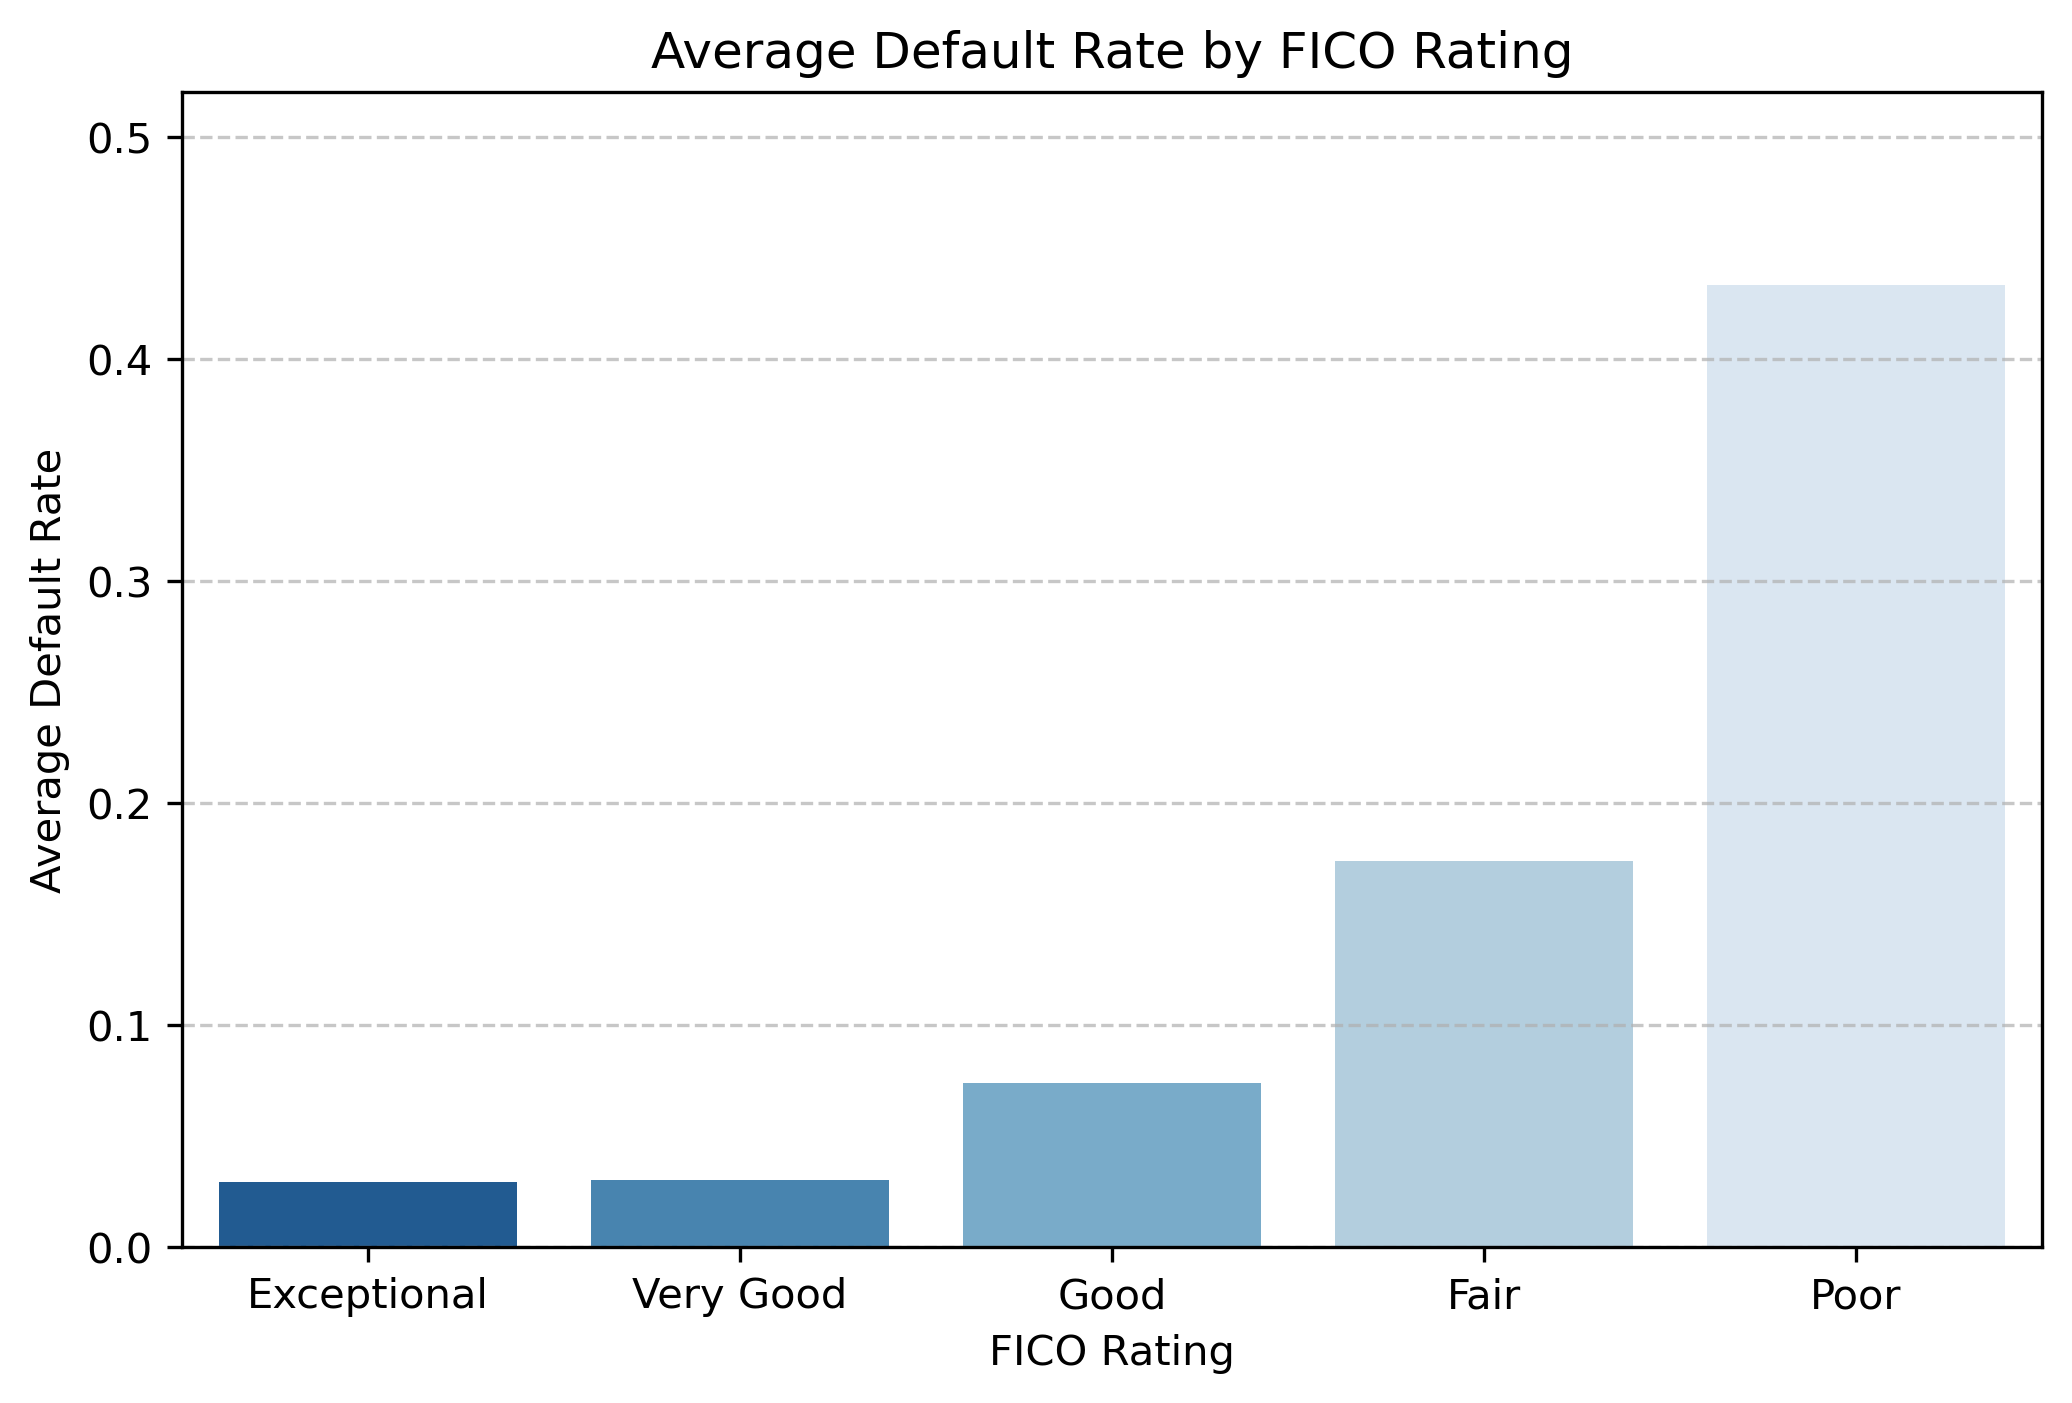

  fico_rating   default rating_label
0           1  0.029412  Exceptional
1           2  0.030227    Very Good
2           3  0.073802         Good
3           4  0.174003         Fair
4           5  0.433634         Poor


In [8]:
# Calculate average default rate per bucket
avg_default = df.groupby('fico_rating', observed=True)['default'].mean().reset_index()

# Map rating numbers to descriptive labels
rating_labels = {1: "Exceptional", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}
avg_default['rating_label'] = avg_default['fico_rating'].map(rating_labels)

# Plot
plt.figure(figsize=(8,5), dpi=300)
sns.barplot(x='rating_label', y='default', 
            hue='rating_label', data=avg_default, palette='Blues_r', legend=False)
plt.title('Average Default Rate by FICO Rating')
plt.xlabel('FICO Rating')
plt.ylabel('Average Default Rate')
plt.ylim(0, avg_default['default'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(avg_default)

### Mean Squared Error (MSE)
MSE measures the average squared difference between:
- The actual default (0 = no default, 1 = default)
- And the predicted default probability from your buckets

In [9]:
from sklearn.metrics import mean_squared_error

# True defaults
y_true = df['default']

# Average PD per bucket
avg_pd_per_bucket = df.groupby('fico_rating', observed=True)['default'].mean()

# Predicted PD for each borrower = average PD of their bucket
y_pred = df['fico_rating'].map(avg_pd_per_bucket)

mse = mean_squared_error(y_true, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.1362475387008514


On average, the predicted PDs (probabilities of default) are off from the actual default values by about 13.62%. This is quite decent! Previously our model predict probabilities like 0.03 for "Very Good", then 0.43 for "Poor". But, the actual default value is either 0 or 1 (non-default or default).

Mean Squared Error (MSE) calculates the average of the squared differences between predicted and actual values. This is the formula: 

 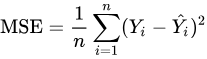

 *(source: wikipedia)*

So if someone didn't default (0), but the model predicted 0.43, the squared error is (0−0.43) x (0−0.43) = **0.1849**.

**Example with 3 data:**
- A, Poor FICO, default (1), predicted PD = 0.43
- B, Very Good FICO, non-default (0), predicted PD = 0.03
- C, Fair, non-default (0), predicted PD

Compute the error for each:
- A: `(1−0.43) x (1−0.43) = 0.3249`
- B: `(0−0.03) x (0−0.03) = 0.0009`
- C: `(0−0.17) x (0−0.17) = 0.0289`
- Now average those: MSE = `(0.3249 + 0.0009 + 0.0289)/3 = 0.1182`
- So on average, the predicted PDs are off by about 11.8%, squared.

#### So why is our MSE is 13.62% (or 0.1362)?
- The predictions (`y_pred`) are based on average PD per bucket, not personalized for each borrower.
- So everyone in the same FICO rating bucket gets the same predicted probability.
- But in reality (`y_true`), some of them defaulted and some didn’t. So there's variability within each bucket (example: everyone in 'Poor' rating has a 43% chance to default. Some defaulted, some didn’t. It's not exactly 43% for every person).
- That “noise” or variability causes the error to increase, and MSE reflects that.

### Logistic Regression and Log Loss

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

X = df[['fico_rating']] 
y = df['default']        

# Train logistic regression
model = LogisticRegression()
model.fit(X, y)

# Predict default probabilities
y_prob = model.predict_proba(X)[:, 1]

# Calculate log loss
ll = log_loss(y, y_prob)
print("Log Loss:", ll)

Log Loss: 0.43413247654947756


### What is Log Loss?
Log loss for binary classification (also called binary cross-entropy) measures how "off" the predicted probabilities are from the actual labels. It gives:
- Confident wrong predictions (very harsh punishment)
- Less confident correct predictions (mild punishment)
- Confident correct predictions (rewards)
  
**So lower the log loss score is, the better.**

Now for example, let's say we have 3 data:
- A, default (1), predicted PD = 0.9
- B, non-default (0), predicted PD = 0.8
- C, non-default (0), predicted PD = 0.6

This means: 
- A will get rewarded
- B will be punished harshly
- C will get a mild punishment

Now let's compute it for each sample:
- A: `−[1⋅log(0.9)+0⋅log(0.1)]=−log(0.9)≈0.105`
- B: `−[0⋅log(0.8)+1⋅log(1−0.8)]=−log(0.2)≈1.609`
- C: `=−log(0.6)≈0.511`
- final log loss (average): `(0.105+1.609+0.511)/3 = 0.742`

So yeah, that one wrong prediction (sample B) hurts the final log loss a lot. 

**Our log loss result: ≈ 0.4341**
- not perfect, but not bad either.
- It suggests that the model's predicted probabilities are fairly close to the true default labels.
- We're only using single feature (`fico_rating`), so a log loss of ~0.43 is quite decent.

## Dynamic Programming
This is a dynamic programming solution to find the optimal 5 buckets that minimize Mean Squared Error (MSE) when mapping FICO scores to average default rates.

In [14]:
import numpy as np

df_sorted = df.sort_values('fico_score').reset_index(drop=True)

# Extract arrays for speed
fico = df_sorted['fico_score'].values
default = df_sorted['default'].values
n = len(fico)

# Precompute cumulative sums for defaults and squared defaults
cum_sum = np.cumsum(default)
cum_sum_sq = np.cumsum(default**2)

# Function to compute MSE for segment [i, j] (inclusive)
def segment_mse(i, j):
    length = j - i + 1
    if length == 0:
        return 0
    sum_ = cum_sum[j] - (cum_sum[i-1] if i > 0 else 0)
    mean_ = sum_ / length
    sum_sq_ = cum_sum_sq[j] - (cum_sum_sq[i-1] if i > 0 else 0)
    mse = sum_sq_ - 2 * mean_ * sum_ + length * mean_**2
    return mse

# Number of buckets
k = 5

# DP arrays
dp = np.full((n, k), np.inf)  # dp[i][j] = min mse for first i+1 points in j+1 buckets
split = np.zeros((n, k), dtype=int)  # split points

# Initialize for 1 bucket (j=0)
for i in range(n):
    dp[i][0] = segment_mse(0, i)

# Fill dp for more buckets
for j in range(1, k):
    for i in range(j, n):
        # Try all possible previous splits
        for m in range(j-1, i):
            cost = dp[m][j-1] + segment_mse(m+1, i)
            if cost < dp[i][j]:
                dp[i][j] = cost
                split[i][j] = m

# Recover bucket boundaries
boundaries = []
idx = n - 1
for j in reversed(range(k)):
    boundaries.append(idx)
    idx = split[idx][j]
boundaries = boundaries[::-1]

# Convert indices to actual FICO scores (bucket boundaries)
bucket_bounds = [fico[0] - 1]  # start slightly below min FICO
for b in boundaries[:-1]:
    bucket_bounds.append(fico[b])
bucket_bounds.append(fico[-1] + 1)  # max boundary slightly above max FICO

print("Optimal bucket boundaries:", bucket_bounds)

# Assign buckets
def assign_bucket(x):
    for i in range(len(bucket_bounds) - 1):
        if bucket_bounds[i] < x <= bucket_bounds[i + 1]:
            return len(bucket_bounds) - 1 - i  # Reverse the bucket number
    return 1 

df_sorted['optimal_bucket'] = df_sorted['fico_score'].apply(assign_bucket)
print(df_sorted.groupby('optimal_bucket')['default'].mean())

Optimal bucket boundaries: [407, 502, 553, 608, 649, 851]
optimal_bucket
1    0.078059
2    0.167547
3    0.282628
4    0.481481
5    0.720238
Name: default, dtype: float64


The dynamic programming quantization worked successfully! This code:
- Bucketed FICO scores into a fixed number of categorical labels (5 ratings).
- Ensured lower bucket labels mean better credit score.
- Used a quantization approach that optimized mean squared error (MSE).
- Produced default probability stats for each bucket.